In [1]:
import sys
from pathlib import Path

# Adding project root to path
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import pandas as pd

processed_df = pd.read_csv(
    PROJECT_ROOT / "data" / "processed" / "processed_churn.csv"
)

processed_df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.280248,-1.161694,-0.994194,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0.064303,-0.260878,-0.173740,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,-1.239504,-0.363923,-0.959649,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0.512486,-0.747850,-0.195248,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,-1.239504,0.196178,-0.940457,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


### Train test split

In [3]:
from src.model_utils import split_features_target, train_test_split_data

X, y = split_features_target(processed_df)

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_train.shape, X_test.shape

((5625, 30), (1407, 30))

### Training the Baseline model

In [4]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(max_iter = 1000)
baseline_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### Predictions

In [5]:
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

### Metrics

In [6]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score, 
    classification_report
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8045486851457001
Precision: 0.649546827794562
Recall: 0.5748663101604278
F1 score: 0.6099290780141844
ROC-AUC: 0.8360144638688001

Classification report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



#### Baseline Model Results (Logistic Regression)

- Accuracy: 80%
- Recall: Moderate (57%) (Could be improved)
- ROC-AUC: Acceptable baseline

This model serves as a benchmark for more complex models

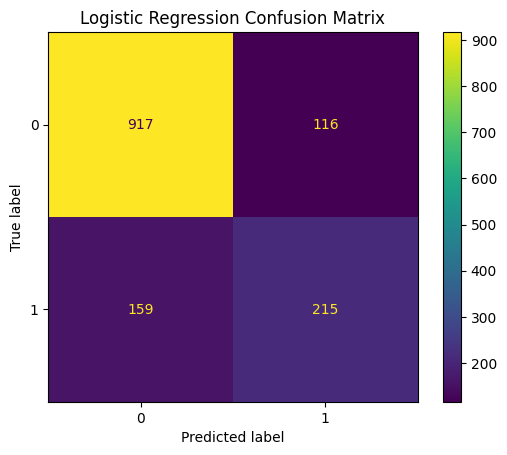

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    baseline_model, 
    X_test, 
    y_test
)

plt.title("Logistic Regression Confusion Matrix")
plt.show()

### Random Forest Model

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators = 200,
    max_depth = 10, 
    random_state = 42,
    class_weight = "balanced"
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

### XGBoost

In [9]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators = 300,
    max_depth = 5,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    eval_metric = "logloss",
    random_state = 42
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

### Evaluating all models together

In [10]:
from src.model_utils import evaluate_model

results = {}

results["LogisticRegression"] = evaluate_model(
    baseline_model, X_test, y_test
)

results["Random Forest"] = evaluate_model(
    rf_model, X_test, y_test
)

results["XGBoost"] = evaluate_model(
    xgb_model, X_test, y_test
)

results

{'LogisticRegression': {'accuracy': 0.8045486851457001,
  'precision': 0.649546827794562,
  'recall': 0.5748663101604278,
  'f1': 0.6099290780141844,
  'roc_auc': 0.8360144638688001},
 'Random Forest': {'accuracy': 0.7718550106609808,
  'precision': 0.5520628683693517,
  'recall': 0.7513368983957219,
  'f1': 0.636466591166478,
  'roc_auc': 0.8351835938106651},
 'XGBoost': {'accuracy': 0.7839374555792467,
  'precision': 0.6080246913580247,
  'recall': 0.5267379679144385,
  'f1': 0.5644699140401146,
  'roc_auc': 0.8273925692779971}}

### Comparison table

In [11]:
import pandas as pd

results_df = pd.DataFrame(results).T
results_df

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.804549,0.649547,0.574866,0.609929,0.836014
Random Forest,0.771855,0.552063,0.751337,0.636467,0.835184
XGBoost,0.783937,0.608025,0.526738,0.564470,0.827393


### Model Selection Decision
Although Logistic Regression achieved the highest accuracy and ROC-AUC,
Random Forest was selected as the primary model due to its superior recall and F1 score.

In a churn prediction context, identifying as many potential churners as possible is more valuable than maximizing accuracy alone.

### Global Feature Importance (Random Forest)

In [12]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)

,feature,importance
0,tenure,0.181045
2,TotalCharges,0.144008
1,MonthlyCharges,0.101873
25,Contract_Two year,0.099021
10,InternetService_Fiber optic,0.064272
28,PaymentMethod_Electronic check,0.054147
24,Contract_One year,0.041415
13,OnlineSecurity_Yes,0.031945
19,TechSupport_Yes,0.023447
18,TechSupport_No internet service,0.019221


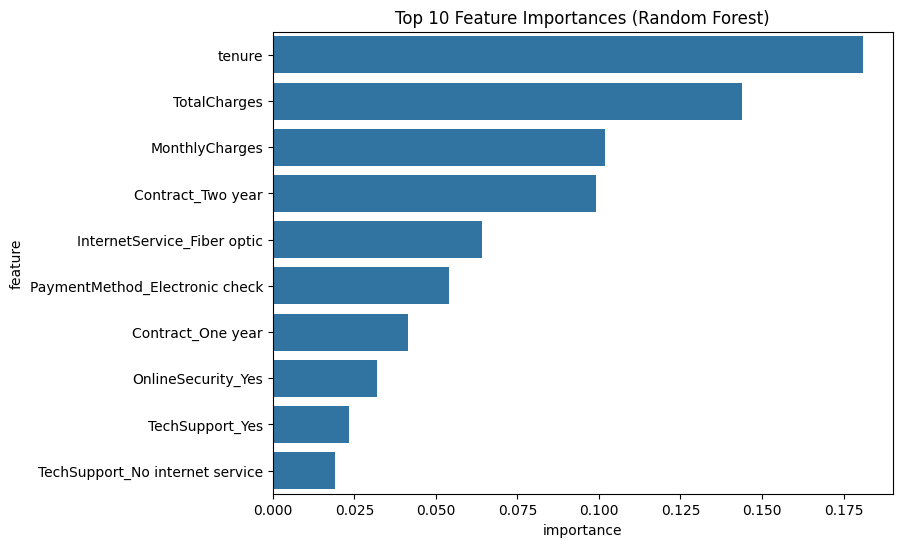

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(
    data = feature_importance.head(10),
    x = "importance",
    y = "feature"
)

plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

### SHAP (Explains what affects features)

In [ ]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)


'\nshap.summary_plot(\n    shap_values[1], # class 1 = churn\n    X_test\n)\n'

In [19]:
type(shap_values)
if isinstance(shap_values, list):
    print("List of SHAP arrays")
    for i, sv in enumerate(shap_values):
        print(f"Class {i} SHAP shape:", sv.shape)
else:
    print("Single SHAP array shape:", shap_values.shape)


Single SHAP array shape: (1407, 30, 2)


- Encountered a shape mismatch error
- SHAP output structure varies by model and version.
- The SHAP values were inspected to ensure correct feature alignment.

In [23]:
shap_values_class_1 = shap_values
assert shap_values_class_1.shape[1] == X_test.shape[1]



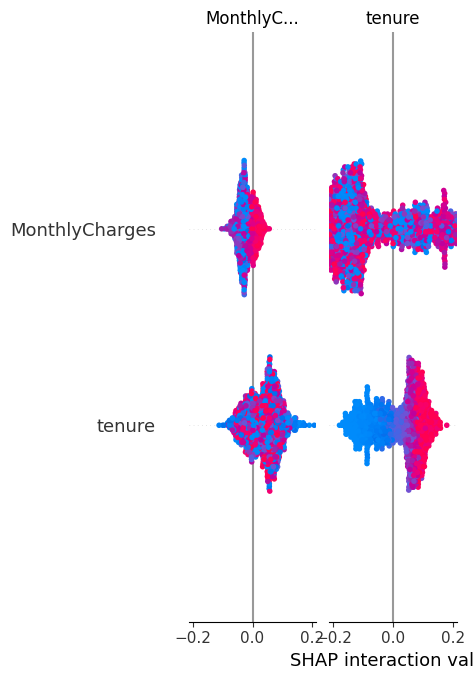

In [24]:
shap.summary_plot(
    shap_values_class_1, # class 1 = churn
    X_test,
    plot_type = "bar"
)


## Model Explainability Summary

SHAP analysis shows that tenure, contract type, and monthly charges
are the most influential features driving churn.

Customers with short tenure, month-to-month contracts, and higher
monthly charges have a significantly higher probability of churn.

These insights can be used by the business to design targeted
retention strategies such as contract upgrades or loyalty discounts.
